In [1]:
import keras
from keras.models import Sequential

Using TensorFlow backend.


In [2]:
from keras.models import load_model

In [3]:
# If load_model fails with following error
# Optimizer weight shape (25088, 4096) not compatible with provided weight shape (4096, 2)
import h5py
f = h5py.File('cats_vs_dogs_retrain_all_dense_layer_ft1.h5', 'r+')

In [4]:
f['optimizer_weights']

<HDF5 group "/optimizer_weights" (5 members)>

In [5]:
del f['optimizer_weights']

In [6]:
f.close()

In [7]:
model = load_model('cats_vs_dogs_retrain_all_dense_layer_ft1.h5')

In [9]:
from keras.preprocessing import image
def get_batches(path, gen=image.ImageDataGenerator(), shuffle=True, batch_size=8, class_mode='categorical'):
    return gen.flow_from_directory(path, target_size=(224,224),
                class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

In [10]:
path = 'dogscats/'
batch_size = 64
gen=image.ImageDataGenerator()
test_batch = gen.flow_from_directory(path+'test1', target_size=(224,224), class_mode=None,
                       shuffle=False, batch_size=1)

Found 12500 images belonging to 1 classes.


In [12]:
predictions = model.predict_generator(test_batch, test_batch.nb_sample)

In [13]:
test = ''
filenames = test_batch.filenames
for i in range(len(filenames)):
    image_id = filenames[i].split('/')[1].split('.jpg')[0]
    cat_prob = int(predictions[i][0])
    is_cat = 1 - cat_prob
    test = test + str(image_id) + ',' + str(is_cat) + '\n'

In [14]:
f = open('dogs_cats_all_dense_layer_ft_submit.csv', 'w')
f.write(test)
f.close()

### Submission resulted in 0.64, increase in 0.01 from 0.63.
# Underfitting
### We are still doing underfitting, as our train accuracy is lower than validation accuracy.

In [15]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 224, 224, 3)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 224, 224, 64)  1792        lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 224, 224, 64)  36928       convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 112, 112, 64)  0           convolution2d_2[0][0]            
___________________________________________________________________________________________

# Lets Remove all dropout layers .

In [17]:
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Convolution2D, MaxPooling2D

# separating all convolution layer and FC layer
layers = model.layers
last_conv_idx = [index for index,layer in enumerate(layers) 
                     if type(layer) is Convolution2D][-1]
conv_layers = layers[:last_conv_idx+1]
conv_model = Sequential(conv_layers)
# Dense layers - also known as fully connected or 'FC' layers
fc_layers = layers[last_conv_idx+1:]

In [18]:
from keras.utils.np_utils import to_categorical as onehot

In [19]:
batches = get_batches(path+'train', shuffle=False, batch_size=batch_size)
val_batches = get_batches(path+'valid', shuffle=False, batch_size=batch_size)

val_classes = val_batches.classes
trn_classes = batches.classes
val_labels = onehot(val_classes)
trn_labels = onehot(trn_classes)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [20]:
batches.class_indices

{'cats': 0, 'dogs': 1}

In [21]:
trn_features = conv_model.predict_generator(batches, batches.nb_sample)
val_features = conv_model.predict_generator(val_batches, val_batches.nb_sample)

In [22]:
import bcolz

def save_array(fname, arr):
    c=bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()

def load_array(fname):
    return bcolz.open(fname)[:]

In [24]:
model_path = path + 'models/'
save_array(model_path + 'train_convlayer_features.bc', trn_features)
save_array(model_path + 'valid_convlayer_features.bc', val_features)
trn_features = load_array(model_path+'train_convlayer_features.bc')
val_features = load_array(model_path+'valid_convlayer_features.bc')

In [25]:
trn_features.shape

(23000, 14, 14, 512)

In [26]:
# Copy the weights from the pre-trained model.
# Since we're removing dropout which was 50% we want to half the weights
def proc_wgts(layer): return [o/2 for o in layer.get_weights()]

In [27]:
from keras.optimizers import RMSprop
# Such a finely tuned model needs to be updated very slowly!
opt = RMSprop(lr=0.00001, rho=0.7)

In [28]:
fc_model_no_dropout = Sequential([
    MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.),
    Dense(4096, activation='relu'),
    Dropout(0.),
    Dense(2, activation='softmax')
])

In [29]:
for new_layer, old_layer in zip(fc_model_no_dropout.layers, fc_layers):
    new_layer.set_weights(proc_wgts(old_layer))

In [30]:
fc_model_no_dropout.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [32]:
fc_model_no_dropout.fit(trn_features, trn_labels, nb_epoch=8,
                        batch_size=batch_size, validation_data=(val_features, val_labels))

Train on 23000 samples, validate on 2000 samples
Epoch 1/8
23000/23000 [==============================] - 51s - loss: 0.0582 - acc: 0.9797 - val_loss: 0.0564 - val_acc: 0.9805

# Now we are doing Overfitting

## how to combat overfitting.
1. Add more data - which is always tough to get clean and reliable data.
2. Data augmentation - generate fake data with little perturbations
3. Regularization
4. Reduce architecture complexity.

## Data augmentation

In [33]:
gen = image.ImageDataGenerator(rotation_range=10, width_shift_range=0.1, 
       height_shift_range=0.1, shear_range=0.15, zoom_range=0.1, 
       channel_shift_range=10., horizontal_flip=True, dim_ordering='tf')

In [41]:
import numpy as np
from scipy import misc, ndimage
# Create a 'batch' of a single image
img = np.expand_dims(ndimage.imread('dogscats/test1/unknown/8.jpg'),0)
# Request the generator to create batches from this image
aug_iter = gen.flow(img)

In [42]:
# Get eight examples of these augmented images
aug_imgs = [next(aug_iter)[0].astype(np.uint8) for i in range(8)]

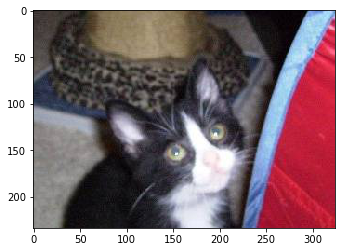

In [43]:
%matplotlib inline
from matplotlib import pyplot as plt
# The original
plt.imshow(img[0])

In [44]:
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

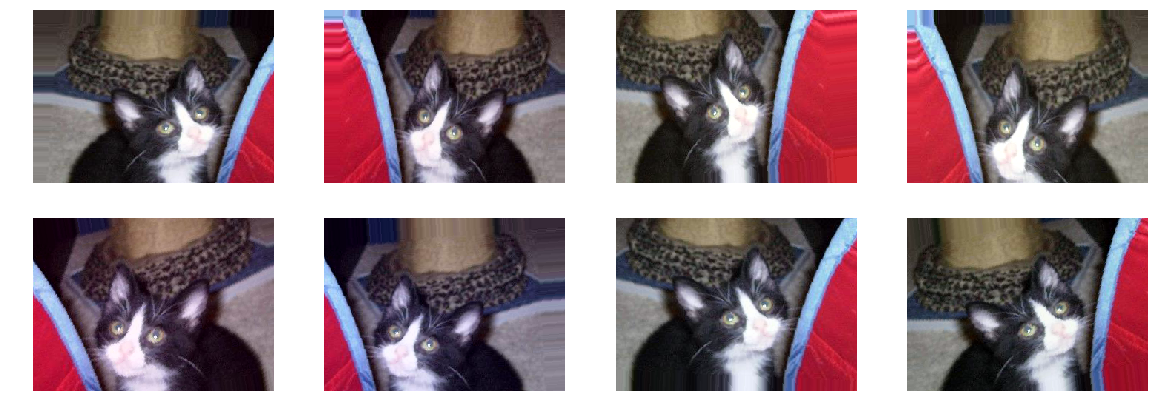

In [45]:
# Augmented data
plots(aug_imgs, (20,7), 2)

In [46]:
gen = image.ImageDataGenerator(rotation_range=15, width_shift_range=0.1, 
                               height_shift_range=0.1, zoom_range=0.1, horizontal_flip=True)

In [47]:
batches = get_batches(path+'train', gen, batch_size=batch_size)
# NB: We don't want to augment or shuffle the validation set
val_batches = get_batches(path+'valid', shuffle=False, batch_size=batch_size)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [48]:
fc_model_no_dropout = Sequential([
    MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.),
    Dense(4096, activation='relu'),
    Dropout(0.),
    Dense(2, activation='softmax')
])

In [49]:
for new_layer, old_layer in zip(fc_model_no_dropout.layers, fc_layers):
    new_layer.set_weights(proc_wgts(old_layer))

fc_model_no_dropout.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Conv model + FC model no dropout

In [50]:
for layer in conv_model.layers:
    layer.trainable = False
# Look how easy it is to connect two models together!
conv_model.add(fc_model_no_dropout)

In [51]:
conv_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Augmented Training

In [52]:
conv_model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=8, 
                        validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Epoch 1/8
23000/23000 [==============================] - 670s - loss: 0.0745 - acc: 0.9718 - val_loss: 0.0693 - val_acc: 0.9770

In [53]:
conv_model.save_weights(model_path + 'dogs_cats_aug1.h5')
conv_model.load_weights(model_path + 'dogs_cats_aug1.h5')